# Chewing the fat on Canadian Cheeses

## Classifying fat content of cheeses using supervised machine learning models

#### Eric G. Dennis  

#### Prepared and submitted as part of "Introduction to Machine Learning"

# Introduction

## Question of Interest

For this project, I will be ultilizing various machine learning models on the presented dataset of Canadian cheeses to attempt to classify the cheeses for their fat content, either as lower fat or higher fat. For this end, I will compare the machine learning models KNN-Classifier, Support Vector Classifier, and RandomForest Classifer to determine the most appropriate model for fat level classification. Considering the features available for each cheese, I hypothesize that a similarity-based model will be most effective for this classification. For the purpose of this project, higher_fat will be considered the positive class in the results and discussions as it is present in a smaller proportion than lower_fat in the dataset.

## Describing the Dataset

The dataset being used in this project,  **cheese_data.csv**  has been curated by Kaggle from data obtained by the  Canadian Dairy Information Centre (CDIC) in collaboration with the Ministère de l'Agriculture, des Pêcheries et de l'Alimentation du Québec (MAPAQ), located [here](https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b). It describes a number of attributes of Canadian Cheeses produced from cow, goat, sheep, or buffalo milk. The attributes in this dataset that could contribute to the classification of the cheeses as lower or higher fat include:
- The province where the cheese was manufactured.
- The manufacturing process utilized to produce the cheese.
- The moisture content of the cheese expressed as a percentage.
- Notes on flavour characteristics. 
- Notes on the cooking and preparation characteristics.
- A classification if the cheese is produced using organic farming processes or not.
- A classification of the cheese firmness and appearance.
- The animal milk used to produce the cheese.
- A classification of how the milk was treated prior to cheese making.
- Notes on the rind type of the cheese.
- The cheese's commercial name.
- The true classification of the cheese as lower fat or higher fat. 
These attributes will be considered in the exploratory data analysis to decide if they will be used to contribute to the prediction models that will follow.

# Methods and Results

A good place to start is to open the **cheese_data CSV** and take a look at what data is available. The dataframe head, data types, and the overall statistics for each column will be useful to determine if the column contains numeric or categorical data. 

Importing some basic wrangling tools will also be useful.

In [1]:
import pandas as pd
import altair as alt
import numpy as np

cheese_df_full = pd.read_csv('data/cheese_data.csv')
cheese_df_full.head()

,CheeseId,ManufacturerProvCode,ManufacturingTypeEn,MoisturePercent,FlavourEn,CharacteristicsEn,Organic,CategoryTypeEn,MilkTypeEn,MilkTreatmentTypeEn,RindTypeEn,CheeseName,FatLevel
0,228,NB,Farmstead,47.0,"Sharp, lactic",Uncooked,0,Firm Cheese,Ewe,Raw Milk,Washed Rind,Sieur de Duplessis (Le),lower fat
1,242,NB,Farmstead,47.9,"Sharp, lactic, lightly caramelized",Uncooked,0,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Tomme Le Champ Doré,lower fat
2,301,ON,Industrial,54.0,"Mild, tangy, and fruity","Pressed and cooked cheese, pasta filata, inter...",0,Firm Cheese,Cow,Pasteurized,NaN,Provolone Sette Fette (Tre-Stelle),lower fat
3,303,NB,Farmstead,47.0,Sharp with fruity notes and a hint of wild honey,NaN,0,Veined Cheeses,Cow,Raw Milk,NaN,Geai Bleu (Le),lower fat
4,319,NB,Farmstead,49.4,Softer taste,NaN,1,Semi-soft Cheese,Cow,Raw Milk,Washed Rind,Gamin (Le),lower fat


In [2]:
cheese_df_full.info()
cheese_df_full.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CheeseId              1042 non-null   int64  
 1   ManufacturerProvCode  1042 non-null   object 
 2   ManufacturingTypeEn   1042 non-null   object 
 3   MoisturePercent       1028 non-null   float64
 4   FlavourEn             801 non-null    object 
 5   CharacteristicsEn     643 non-null    object 
 6   Organic               1042 non-null   int64  
 7   CategoryTypeEn        1019 non-null   object 
 8   MilkTypeEn            1041 non-null   object 
 9   MilkTreatmentTypeEn   977 non-null    object 
 10  RindTypeEn            721 non-null    object 
 11  CheeseName            1042 non-null   object 
 12  FatLevel              1042 non-null   object 
dtypes: float64(1), int64(2), object(10)
memory usage: 106.0+ KB


,CheeseId,MoisturePercent,Organic
count,1042.000000,1028.000000,1042.000000
mean,1560.633397,47.069747,0.095010
std,451.811164,9.592647,0.293369
min,228.000000,12.000000,0.000000
25%,1280.250000,40.000000,0.000000
50%,1548.500000,46.000000,0.000000
75%,1901.750000,52.000000,0.000000
max,2391.000000,92.000000,1.000000


There are multiple columns that contain null values, and its important to consider whether these missing values can be imputed or if the column is missing sufficient data that it warrants being dropped from the dataframe for the model development.

The function below will provide an output of the number of columns missing values; and a table that displays the total number of missing values and the percentage of missing values for each column identified that contains missing values.
I cannot claim ownership of this function, I found it on StackOverflow in [this thread](https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe). 
Plotting the percentages of NaN values will allow us to determine a cutoff value for dropping columns.

In [3]:
# Defining the missing values table function and producing the table of the cheese_df_full.

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

nan_percent = missing_values_table(cheese_df_full)
nan_percent = nan_percent.reset_index() 
nan_percent
#Needed to reset the index in order to create a column with column names included in the dataframe for plotting.

Your selected dataframe has 13 columns.
There are 7 columns that have missing values.


,index,Missing Values,% of Total Values
0,CharacteristicsEn,399,38.3
1,RindTypeEn,321,30.8
2,FlavourEn,241,23.1
3,MilkTreatmentTypeEn,65,6.2
4,CategoryTypeEn,23,2.2
5,MoisturePercent,14,1.3
6,MilkTypeEn,1,0.1


In [4]:
#Plotting the %missing values in the columns identified from the nan_percent table.

nan_percent_plot = alt.Chart(nan_percent, width=500, height=300).mark_bar().encode(
                   x=alt.X('index:N', sort='y', title="Name of column"),
                   y=alt.Y('% of Total Values:Q', title="% of missing values")
         ).properties(title="Display of %missing values in columns of cheese_df_full")
nan_percent_plot

alt.Chart(...)

From this initial look at the data and the instructions provided for the assignment, the following columns are suitable for dropping:
1) *CheeseId*, as it does not provide any predictive value.

2) *FlavourEn*, *CharacteristicsEn*, *RindtypeEN*. These are all descriptive, which can be difficult to process. But more importantly they contain more than 20% missing values. These percentages are large enough that using methods such as imputation would be of questionable value to the models. The other four columns with missing values are 6% or fewer missing values, and can be handled with imputation.

In [5]:
#Drop these columns.
cheese_df = cheese_df_full.drop(columns=['CheeseId', 'FlavourEn', 'CharacteristicsEn', 'RindTypeEn'])
cheese_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  1042 non-null   object 
 1   ManufacturingTypeEn   1042 non-null   object 
 2   MoisturePercent       1028 non-null   float64
 3   Organic               1042 non-null   int64  
 4   CategoryTypeEn        1019 non-null   object 
 5   MilkTypeEn            1041 non-null   object 
 6   MilkTreatmentTypeEn   977 non-null    object 
 7   CheeseName            1042 non-null   object 
 8   FatLevel              1042 non-null   object 
dtypes: float64(1), int64(1), object(7)
memory usage: 73.4+ KB


The following data will be useful in deciding the determining the necessary aspects in preprocessing the dataframe:
1) The number of unique values in each column.

2) The ratio of lower to higher fat cheeses in the *FatLevel* target column.

In [6]:
#Calculating the unique values in each column.
unique_values = cheese_df.nunique(axis=0) 
print(unique_values)

ManufacturerProvCode      10
ManufacturingTypeEn        3
MoisturePercent           68
Organic                    2
CategoryTypeEn             6
MilkTypeEn                 8
MilkTreatmentTypeEn        3
CheeseName              1038
FatLevel                   2
dtype: int64


In [7]:
#Plotting the lower to higher fat ratio in the FatLevel column.
fat_ratio = cheese_df.value_counts('FatLevel')
print(fat_ratio)
fat_ratio_bar = alt.Chart(cheese_df, width=500, height=300).mark_bar().encode(
                   x=alt.X('FatLevel:N', sort='-y', title="Fat Level of Cheese"),
                   y=alt.Y('count():Q', title="Count of total Lower and Higher fat cheeses")
         ).properties(title="Comparison of toal number of Lower and Higher fat cheeses in cheese_df")
fat_ratio_bar

FatLevel
lower fat     684
higher fat    358
dtype: int64


alt.Chart(...)

From the unique values table and FatLevel comparison plot, we can ascertain:
1) A scaling of the training data is appropriate given the wide variation in the number of unique values for each column.

2) The FatLevel comparison shows an approximately 1:2 ratio of higher and lower fat cheeses. This imbalance in the ratio is not sufficient to need to call on any balancing in preprocessing. Let's proceed with the *FatLevel* data as it is. 

With our appropriate feature and target columns selected, time to split our training and test data and define our X and y dataframes before we dive into any processing. A 20% test size seems reasonable in our dataset of approximately 1000 examples.

In [8]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(cheese_df, test_size=0.2, random_state=1)

X_train = train_df.drop(columns='FatLevel')
X_test = test_df.drop(columns='FatLevel')
y_train = train_df['FatLevel']
y_test = test_df['FatLevel']

The column info of **train_df** is useful to help decide how to group the features as categorical, numeric, binary or ordinal.

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 833 entries, 429 to 235
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ManufacturerProvCode  833 non-null    object 
 1   ManufacturingTypeEn   833 non-null    object 
 2   MoisturePercent       822 non-null    float64
 3   Organic               833 non-null    int64  
 4   CategoryTypeEn        813 non-null    object 
 5   MilkTypeEn            832 non-null    object 
 6   MilkTreatmentTypeEn   777 non-null    object 
 7   CheeseName            833 non-null    object 
 8   FatLevel              833 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 65.1+ KB


*Moisture%* and *Organic* are numeric. All the other features are best classified as categorical as there isnt any logical way to rank the unique values, so a onehotencoder is most appropriate preprocessing of these features. 
For now, we will drop *CheeseName* from the features. For now, let's do some modelling without the name and incorporate that back on an optimized model if time permits (as March 8 deadline rapidly approaches). 
*Edit March 8, 8pm*, time over the weekend evaporated very quickly and I have not managed to incorporate the *CheeseName* column into any models. 

In [10]:
categorical_features = ['ManufacturerProvCode', 'ManufacturingTypeEn', 'CategoryTypeEn', 'MilkTypeEn', 'MilkTreatmentTypeEn'] 

numeric_features = ['MoisturePercent', 'Organic']
                        
drop_features = ['CheeseName']

*MoisturePercent*, *CategoryTypeEn*, *MilkTypeEn*, and *MilkTreatmentTypeEn* all contain Null values. SimpleImputer is the best way to handle these values. *MoisturePercent* will be imputed with a 'median' strategy, and the categorical features with the 'most_frequent' strategy. 
To finish the transformers, a StandardScalar will be incorporated into the numerical pipeline, and the categorical features will be transformed using OneHotEncoder.

Lets make our transformers.

In [11]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# The numeric transformer pipeline
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())])

# The categorical transformer pipeline
categorical_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Build a column transformer
col_transformer = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)])

Now for some modelling of the data. The baseline DummyClassifier with a "most_frequent" strategy seems the best place to begin. This project will use a cross validation method to compare training and test scores across the different models.

This is a good time to note that the default accuracy will be used as our scoring method for this project. We are trying to classify lower fat or higher fat cheeses. There are no extenuating necessities to try to reduce the number of false positives or negatives such as predicting a disease where false negatives can have drastic consequences for health of an individual. The most important target for the models are to get as many cheeses correctly as lower fat or higher fat, and that target is best scored with accuracy.

In [12]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

#A pipeline with the preprocessor and DummyClassifier is needed.

dummy_pipe = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("dummy",  DummyClassifier(strategy="most_frequent"))])

#Lets cross validate and get a dummyscores dataframe.

dummy_scores = pd.DataFrame(cross_validate(dummy_pipe, X_train, y_train, cv=5, return_train_score=True))
dummy_scores


,fit_time,score_time,test_score,train_score
0,0.082788,0.008113,0.658683,0.656156
1,0.019959,0.008510,0.658683,0.656156
2,0.022391,0.008117,0.652695,0.657658
3,0.019276,0.007991,0.656627,0.656672
4,0.018651,0.007975,0.656627,0.656672


The mean average values of the train and test scores of the CV are needed as a useful comparison for the more complex models to come.

In [13]:
dummy_train_mean = dummy_scores['train_score'].mean()
dummy_test_mean = dummy_scores['test_score'].mean()
print(dummy_train_mean, dummy_test_mean)

0.6566626596611604 0.6566625784575427


These are reasonable numbers for a baseline, and is certainly neither over- or under-fit.

The training data will now be explored using KNN, SVC, and RandomForest models with default parameters. As with the baseline model, each will use a 5-fold cross validation and the mean train and test scores will be determined to make comparisons.

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# The knn Pipeline
knn_pipe = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("knn", KNeighborsClassifier())])

# Cross validation of knn model
knn_scores = pd.DataFrame(cross_validate(knn_pipe, X_train, y_train, cv=5, return_train_score=True))
knn_scores

# mean scores of knn model
knn_train_mean = knn_scores['train_score'].mean()
knn_test_mean = knn_scores['test_score'].mean()
print(knn_train_mean, knn_test_mean)

0.8706502604553579 0.8415337998701393


In [33]:
# The RandomForest (RF) Pipeline
forest_pipe = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("forest", RandomForestClassifier(random_state=99))])

# Cross validation of RF model
forest_scores = pd.DataFrame(cross_validate(forest_pipe, X_train, y_train, cv=5, return_train_score=True))
forest_scores

# mean scores of RF model
forest_train_mean = forest_scores['train_score'].mean()
forest_test_mean = forest_scores['test_score'].mean()
print(forest_train_mean, forest_test_mean)

0.9480800140470306 0.8295288940191906


In [16]:
# The SVC Pipeline
svc_pipe = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("svc", SVC(random_state=99))])

# Cross validation of SVC model
svc_scores = pd.DataFrame(cross_validate(svc_pipe, X_train, y_train, cv=5, return_train_score=True))
svc_scores

# mean scores SVC model
svc_train_mean = svc_scores['train_score'].mean()
svc_test_mean = svc_scores['test_score'].mean()
print(svc_train_mean, svc_test_mean)

0.8373340356848603 0.8054974388572254


Each model is showing some overfitting. Calculating the percentage overfitting for each model will help provide some numbers for justifying the best model to continue our analysis.

In [34]:
# Calculating the percentage overfit of the three models
pc_overfit_knn = round(((knn_train_mean-knn_test_mean)/knn_test_mean)*100,1)
pc_overfit_forest = round(((forest_train_mean-forest_test_mean)/forest_test_mean)*100,1)
pc_overfit_svc = round(((svc_train_mean-svc_test_mean)/svc_test_mean)*100,1)
print(pc_overfit_knn, pc_overfit_forest, pc_overfit_svc)

3.5 14.3 4.0


From the mean training and validation scores of the three models, the KNN model appears the most appropriate to continue to work with in hyperparameter tuning for two reasons:
1) It provides the best mean test score of the three models. The SVC is several points lower than both KNN and RF.

2) The overfitting is relatively small. The rough percent calculation puts KNN at ~3.5% overfit, whereas the RF is much higher at ~14.3%.

Looking at the documentation of the KNeighborsClassifier, the n_neighbors and weights hyperparameters have been chosen to compare using GridSearchCV. 
1) The searching of *n_neighbors* 1 to 101 in intervals of 5 have been chosen as reasonable grouping of neighbours to search. Going beyong 101 neighbours is pushing the limits of usefulness in the model.

2) The weight hyperparameters of *uniform* and *distance* have been chosen to explore how these weighting affect the performance of the model. This will give a good comparison of how the model treats neighbours as they get less and less similar.

3) The relatively small number of hyperparameters being used in the search means that computational time is not overly long, so the GridSearchCV makes more sense to use than RandomSearchCV.

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = {"knn__n_neighbors" : np.arange(1, 102, 5),
              "knn__weights" : ["uniform", "distance"]}

knn_search = GridSearchCV(knn_pipe, param_grid, cv=10, verbose=1, n_jobs=-1, return_train_score=True)

knn_search.fit(X_train,y_train)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   43.6s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['MoisturePercent',
                                                                          'Organic']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                  

Calling the parameters of the best estimator and its associated validation score suggests that the model with n_neighbors of 61 and a *distance* weighting is the best scoring model.

In [36]:
knn_search.best_params_
knn_search.best_score_
print(knn_search.best_params_, knn_search.best_score_)

{'knn__n_neighbors': 61, 'knn__weights': 'distance'} 0.8391853126792885


Before proceeding in scoring on the test set, an exploration of the CV results is warranted to get an idea if any over- or underfitting is occurring in the GridSearchCV sweep. This will require some wrangling of the knn_search CV results.

In [38]:
knn_cv_df = pd.DataFrame.from_dict(knn_search.cv_results_)
knn_cv_short = knn_cv_df[['param_knn__n_neighbors', 'param_knn__weights', 'mean_test_score', 'mean_train_score']]
knn_cv_short.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   param_knn__n_neighbors  42 non-null     object 
 1   param_knn__weights      42 non-null     object 
 2   mean_test_score         42 non-null     float64
 3   mean_train_score        42 non-null     float64
dtypes: float64(2), object(2)
memory usage: 1.4+ KB


Some plots of the scores vs number of neighbours values will be useful in our analysis. However, the param_knn__n_neighbors column is an object series, we need is as an int64 dtype in order to plot. While we are here, let's shorten the names of n_neighours and weights columns. In order to produce some meaningful plots from the data, we will need to filter the *uniform* and *distance* columns into separate dataframes.

The following code will allow us to produce two line plots of mean-training-score and mean-test-score vs n_neighbors used in the model, one for *uniform* weighting, and one for *distance*. I spent way too much time trying to plot the two models together without success. In the presence of the looming submission deadline, I will need to break the DRY principle and make two sets of codes to get the desired plots. Perhaps I will need to take the data visualization course to learn how to overlay the plots as I desired.

In [22]:
#cast the param_knn__n_neighbors column as dtype int64

knn_cv_cast = knn_cv_short.rename(columns={'param_knn__n_neighbors':'n_neighbors','param_knn__weights':'knn_weights'})
knn_cv_cast = knn_cv_cast.assign(n_neighbors=knn_cv_cast['n_neighbors'].astype('int'))
knn_cv_cast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   n_neighbors       42 non-null     int64  
 1   knn_weights       42 non-null     object 
 2   mean_test_score   42 non-null     float64
 3   mean_train_score  42 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.4+ KB


In [23]:
# Now we can plan ahead to a line plot.
knn_plot_df = knn_cv_cast.melt(id_vars=['n_neighbors', 'knn_weights'],
                                             value_vars=['mean_train_score',
                                                         'mean_test_score'], 
                                             var_name='split',
                                             value_name='score')

knn_uniform = knn_plot_df[knn_plot_df['knn_weights'] == 'uniform']
knn_distance = knn_plot_df[knn_plot_df['knn_weights'] == 'distance']
knn_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 83
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   n_neighbors  42 non-null     int64  
 1   knn_weights  42 non-null     object 
 2   split        42 non-null     object 
 3   score        42 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.6+ KB


In [43]:
knn_plot_uniform =alt.Chart(knn_uniform).mark_line().encode(
             alt.X('n_neighbors:Q', axis=alt.Axis(title="Number of Neighbours")),
             alt.Y('score:Q', scale=alt.Scale(domain=[.70, 1.00])), 
             alt.Color('split:N', scale=alt.Scale(domain=['mean_train_score', 'mean_test_score'], range=['red', 'blue']))).properties(title="Mean training and mean validation scores for uniform weighting")
knn_plot_uniform


alt.Chart(...)

In [44]:
knn_plot_distance =alt.Chart(knn_distance).mark_line().encode(
             alt.X('n_neighbors:Q', axis=alt.Axis(title="Number of Neighbours")),
             alt.Y('score:Q', scale=alt.Scale(domain=[.70, 1.00])), 
             alt.Color('split:N', scale=alt.Scale(domain=['mean_train_score', 'mean_test_score'], range=['teal', 'gold']))).properties(title="Mean training and mean validation scores for distance weighting")
knn_plot_distance

alt.Chart(...)

The two plots show that both the train and test score rapidly decline in the *uniform* hyperparatmer chart, whereas the scores stay relatively consistent for the *distance* hyperparameter. This is to be expected, as the similarity should decrease as we introduce more neighbours to the model that are getting less and less similar to each other in the *uniform* chart. The *distance* hyperparameter helps to correct for this, hence the relatively stable scores in that chart. The *distance* chart also shows that those models are overfitting more than the *uniform* models.

We need to consider this overfitting in discussing the best estimator and scoring on the test set. For this we need to revist the best parameters for the model, and get the model with the best CV score for each weight hyperparameter. The dataframe knn_cv_cast prepared earlier is best set up to get the data needed.

In [45]:
uniform_bestCV = knn_cv_cast[knn_cv_cast['knn_weights'] == 'uniform'].sort_values(by='mean_test_score', ascending=False)
print(uniform_bestCV.loc[:,'mean_test_score'].max())
uniform_bestCV.head(1)

#This tells us the best CV score for uniform weighting occurs at n_neighbours = 6, with a corresponding training score of 0.863.

0.8342943201376937


,n_neighbors,knn_weights,mean_test_score,mean_train_score
2,6,uniform,0.834294,0.86328


In [27]:
distance_bestCV = knn_cv_cast[knn_cv_cast['knn_weights'] == 'distance'].sort_values(by='mean_test_score', ascending=False)
print(distance_bestCV.loc[:,'mean_test_score'].max())
distance_bestCV.head(1)

#This tells us the best CV score for distance weighting occurs at n_neighbours = 61, with a corresponding training score of 0.946.

0.8391853126792885


,n_neighbors,knn_weights,mean_test_score,mean_train_score
25,61,distance,0.839185,0.946112


The Fundamental Tradeoff rears its head for this situation. The best model according to the knn_search best estimator is the distance_bestCV model where n_neighbours = 61. The CV score is very good at 0.839, but there is signigificant overfitting of the model with the corresponding training score at 0.946. The uniform_bestCV model only scores slightly lower at 0.834, but the training score is 0.863, and hence shows a lot less overfitting. 

Its a tough choice here, but the intuition developed in the limited time of this course tells me that the 0.005 score increase, or 0.5%, is not worth the significant overfitting increase in the distance model vs uniform model. There is a strong case here to score the two models on the **test_df**.

In [28]:
#Scoring the test model on the best uniform weighted model.

best_uniform_pipeline = Pipeline(
    steps=[
        ("preprocessor", col_transformer),
        ("knn", KNeighborsClassifier(n_neighbors=6, weights='uniform'))])

best_uniform_pipeline.fit(X_train, y_train)

best_uni_train = best_uniform_pipeline.score(X_train, y_train)
best_uni_test = best_uniform_pipeline.score(X_test, y_test)
print(best_uni_train, best_uni_test)


0.8643457382953181 0.7607655502392344


In [29]:
#Scoring the test model on the best distance weighted model.

knn_best = knn_search.best_estimator_
knn_best.fit(X_train, y_train)

best_train = knn_best.score(X_train, y_train)
best_test = knn_best.score(X_test, y_test)
print(best_train, best_test)

0.9447779111644657 0.8277511961722488


The distance weighted model provides a much better score on the testing data of 0.828, compared to 0.761 for the uniform weighted model. Comparing the best training set scores, both models show significant overfitting. 

The distance weighted model is clearly the best model for our classification problem, as we can continue in our analysis with a plotting a confusion matrix and classification report on this model.

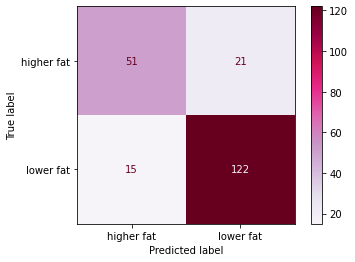

In [46]:
# The confusion matrix and classification report need importing
from sklearn.metrics import plot_confusion_matrix, classification_report

#Now we can plot the confusion matrix.
plot_confusion_matrix(knn_search.best_estimator_, X_test, y_test, cmap="PuRd")

In [47]:
# Finally, let's prepare the classification report on the test set.
predicted_y = knn_search.best_estimator_.predict(X_test)

print(classification_report(y_test, predicted_y, digits=3))

              precision    recall  f1-score   support

  higher fat      0.773     0.708     0.739        72
   lower fat      0.853     0.891     0.871       137

    accuracy                          0.828       209
   macro avg      0.813     0.799     0.805       209
weighted avg      0.825     0.828     0.826       209



The most important take-home points from the confusion matrix and classification report:
1) The model was much more accurate in classifying lower fat than higher fat cheeses. The confusion matrix shows a total of 21 false positives (higher fat cheeses incorrectly labelled as lower fat), but only 15 false negatives (lower fat cheeses incorrectly labelled as higher fat).

2) The overall weighted accuracies are reasonably consistent across all the scoring parameters.

# Discussions 

The preceding analysis compared several supervised machine learning models to deterimine the most appropriate model for classifying cheeses in the dataset provided as lower or higher fat. To this end, it was determined that a K-NeighborsClassifier was the best tool for this target classification. Optimizing hyperparameters showed that the best model utilized 61 n_neighbors and a "distance" weighting. This model provided an accuracy on the test set of 0.828. This is a clear improvement on the baseline model, which scored at 0.657 during cross-validation. 

To address our hypothesis, the similarity-based models of KNN and SVC did indeed perform better than the RandomForestClassifier. The cheeses had multiple characteristics to compare and overlap, and the similarity-based models are better set up to do such multiple comparisons.

The confusion matrix and classification report of the best model highlighted that the false positive rate was much higher than the false negative rate. This is reflected in the 0.773 verses 0.853 precision scores for higher fat and lower fat classifications respectively. This is likely due to smaller number of higher fat cheeses in the overall dataset, and hence there are fewer cheeses to compare to each other. In hindsight, using a balanced class weighting would have likely reduced the false positive rate. Incorporating a CountVectorizer to bring the *CheeseName* feature into the model would also be another suggestion to help improve the models overall accuracy.


# References

I cannot take all the credit for the preceding work. As such, I would like to acknowledge the following resources.

## Resources used
* The cheese dataset source: https://open.canada.ca/data/en/dataset/3c16cd48-3ac3-453f-8260-6f745181c83b
* The code for tabulating the missing values percentage was found in StackOverflow: https://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-a-column-in-pandas-dataframe
* The Scikit Learn documentation for the models utilized: https://scikit-learn.org/

### Question Of Interest
Thanks to my wife, Vanessa Lomas, for her discussions in helping me to keep to a reasonably attainable hypothesis and trying to help me from going overboard as I did in the final project of the Python Introduction course.

### Acknowledgements
Thanks to everyone on the course Piazza community for your insights and inputs into each others projects and assignments. Its been an enjoyable and inclusive place to learn.
Thanks to the Python team at UBC EL for putting together an overall very enjoyable and well organized course. I revisted the module slideshows on many occasions while writing this project.
The many, many, many forums and document webpages I visited throughout the course to help me through my coding errors and doubts.